In [1]:
import tifffile
import numpy as np
import fastplotlib as fpl
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
parent_path = Path("/home/kushal/lab/datasets/adam_cohen/1/")
frame = tifffile.imread(list(parent_path.glob("*.tiff"))[0])
movie = np.memmap(parent_path.joinpath("frames.bin"), dtype=np.uint16)

xdim, ydim = frame.shape
nframes = movie.size / (xdim * ydim)
assert nframes.is_integer()
nframes = int(nframes)

border_trim = 10

movie = movie.reshape(nframes, xdim, ydim)[100:9_000, border_trim:-border_trim, border_trim:-border_trim]
xdim = movie.shape[1]
ydim = movie.shape[2]

In [3]:
movie_mean = movie.mean(axis=0)

In [44]:
iw = fpl.ImageWidget(
    movie, 
    cmap="gnuplot2_r",
    frame_apply={0: lambda f: f - movie_mean},
)
iw.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [19]:
from scipy.sparse.linalg import svds
from tqdm import tqdm
from itertools import product
from time import time

In [45]:
from mesmerize_core.arrays._base import LazyArray

In [ ]:
class LazyTDMovie(LazyArray):
    def __init__(
        self,
        spatial: np.ndarray,
        temporal: np.ndarray
    ):
        self.spatial = spatial
        self.temporal = temporal

    _compute_at_indices

In [33]:
class TdSVD:
    def __init__(
        self,
        movie: np.ndarray,
        n_time_steps: int,
        delay: int,
    ):
        self.n_time_steps = n_time_steps
        self.movie_mean = movie.mean(axis=0)
        
        frame = movie[0]
        self.xdim, self.ydim = frame.shape[0], frame.shape[1]
        
        n_pixels = self.xdim * self.ydim
        n_timepoints = movie.shape[0]
        
        self.A = np.zeros((n_pixels * n_time_steps, n_timepoints - n_time_steps))
        A_ixs = np.zeros(n_pixels * n_time_steps)
        
        for pixel_ix, (x, y) in tqdm(enumerate(product(range(self.xdim), range(self.ydim))), total=n_pixels):
            for step in range(n_time_steps):
                self.A[(n_time_steps * pixel_ix) + step] = np.roll(movie[:, x, y], shift=delay * step)[:-n_time_steps]

        self.k, self.U, self.S, self.V = None, None, None, None
    
    def fit(self, k=6, **kwargs):
        self.k = k
        t0 = time()
        self.U, self.S, self.V = svds(self.A, k=k, **kwargs)
        self.U = self.U[:, ::-1]
        self.S = self.S[::-1]
        self.V = self.V[::-1, :]
        t1 = time()
        print(f"svd took: {t1 - t0:.02f} sec")

    def get_spatial(self):
        return [self.U.reshape((self.xdim, self.ydim, self.n_time_steps, self.k))[..., i, :].transpose(2, 0, 1) for i in range(self.n_time_steps)]

    def get_rcm(self):
        

In [24]:
start_ix, stop_ix = 0, 1000

In [25]:
snippet = movie[start_ix:stop_ix]

In [34]:
td_svd = TdSVD(
    movie=snippet,
    n_time_steps=3,
    delay=1
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 144976/144976 [00:06<00:00, 21193.25it/s]


In [35]:
td_svd.fit(k=8)

svd took: 29.43 sec


In [36]:
spatial = td_svd.get_spatial()

In [37]:
iw = fpl.ImageWidget(
    data=spatial,
    names=[f"step-{i}" for i in range(td_svd.n_time_steps)]
)
iw.show()

RFBOutputContext()

/home/kushal/repos/fastplotlib/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

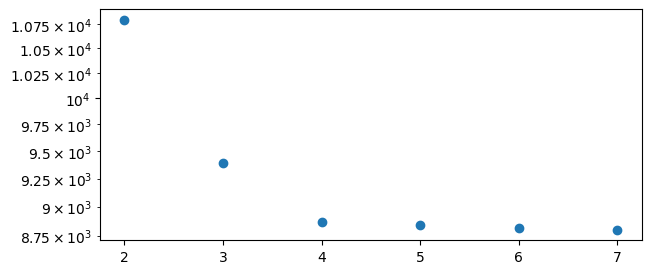

In [40]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(x=np.arange(td_svd.S.size)[2:], y=td_svd.S[2:])
plt.yscale("log")

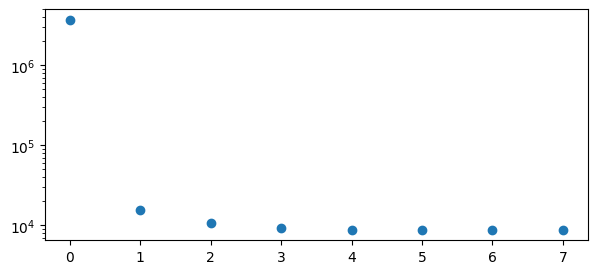

In [41]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(x=np.arange(td_svd.S.size), y=td_svd.S)
plt.yscale("log")

In [42]:
from scipy import signal

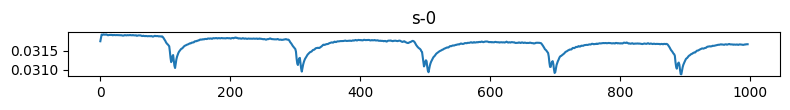

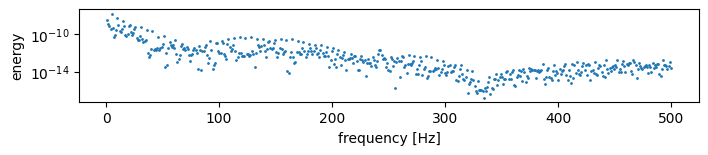

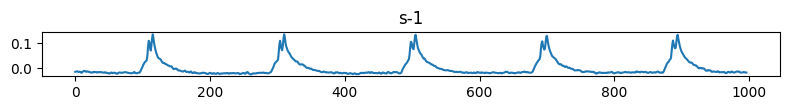

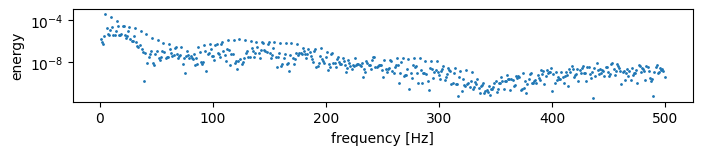

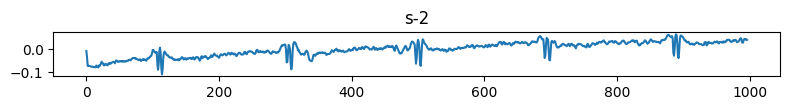

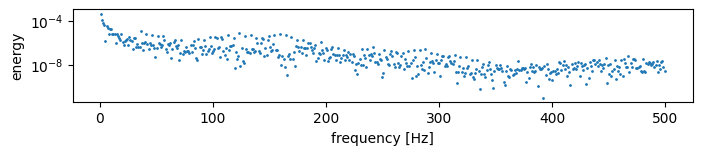

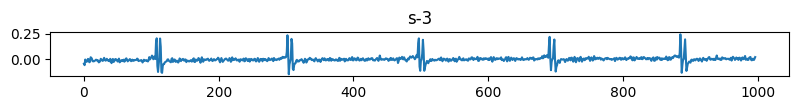

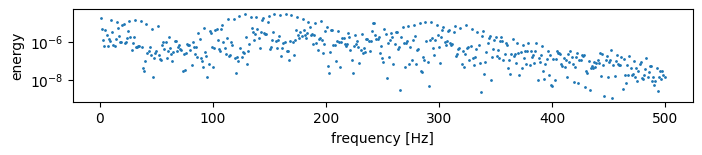

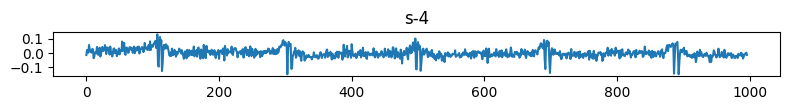

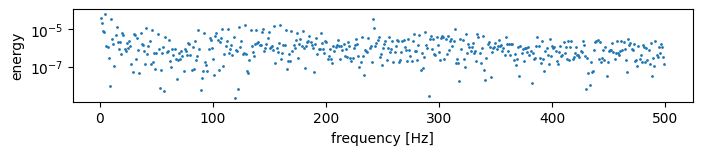

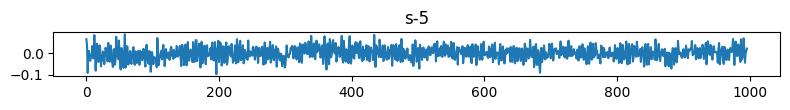

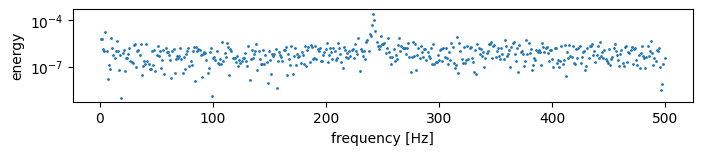

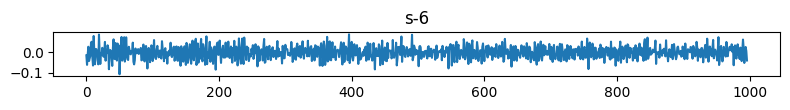

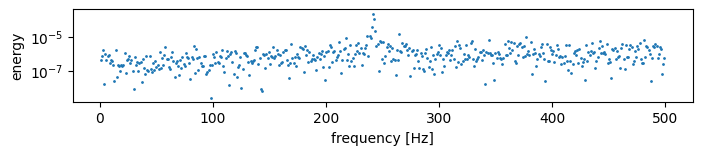

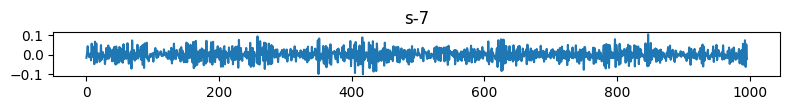

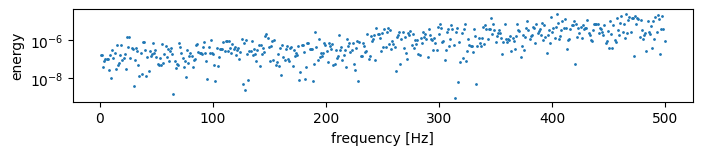

In [43]:
for i in range(td_svd.V.shape[0]):
    fig = plt.figure(figsize=(8, 1.2))
    plt.plot(td_svd.V[i])
    plt.title(f"s-{i}")    
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8, 1.2))
    f, Pxx_den = signal.periodogram(td_svd.V[i], 1_000)
    plt.scatter(f[1:], Pxx_den[1:], s=1)
    plt.yscale("log")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('energy')
    plt.show()
